In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

In [18]:
df = pd.read_csv('/home/max/code/msds-supervised-learning-final/data/winequality-white.csv', sep=';')

# remove spaces from column names
df = df.rename(columns={
    'fixed acidity': 'fixed_acidity', 'volatile acidity':'volatile_acidity',
    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide', 'total sulfur dioxide': 'total_sulfur_dioxide'
})

# thankfully, no NA/missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


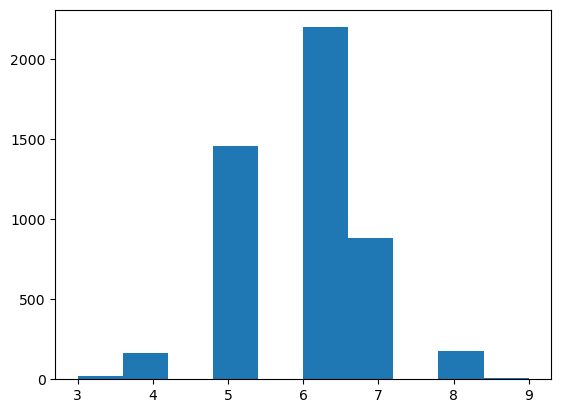

In [19]:
# exploring the ranges of the 'quality' values
df['quality'].hist(grid=False)
plt.show()

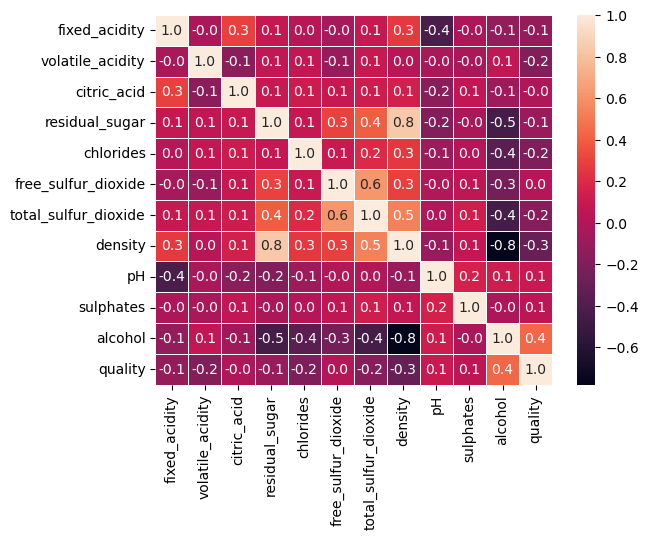

In [99]:
# exploring the corelation matrix
corr = df.corr()

# according to the heatmap, there are no good features 
# strongly correlated with the 'quality' score
sns.heatmap(corr, annot=True, fmt=".1f", linewidth=.5)

In [127]:
# there is no strong correlation between 'quality' and any of the other columns

# get raw correlation values
# sort the matrix by lowest to highest values
corr_pairs = corr.unstack()
sorted_corr_pairs = corr_pairs.sort_values()
print(sorted_corr_pairs['quality'])

# according to the matrix, there are following interesting correlations:
#pos_corr = sorted_corr_pairs[(sorted_corr_pairs.values >= 0.5) & (sorted_corr_pairs.values < 1)]
#neg_corr = sorted_corr_pairs[(sorted_corr_pairs.values <= -0.5) & (sorted_corr_pairs.values > -1)]
#print(pos_corr)
#print(neg_corr)

# positive:
# residual sugar - density = 0.838966
# free sulfur dioxide - total sulfur dioxide = 0.615501
# density - total sulfur dioxide    0.529881
#
# negative:
# alcohol - density = -0.780138


density                -0.218774
volatile_acidity       -0.213074
total_sulfur_dioxide   -0.157961
chlorides              -0.133260
residual_sugar         -0.083344
fixed_acidity          -0.056204
free_sulfur_dioxide    -0.022859
citric_acid             0.001423
sulphates               0.040497
pH                      0.065685
alcohol                 0.339987
quality                 1.000000
dtype: float64


In [61]:
# first ill try to build a linear regression model to predict the raw 'quality' value

# create training and testing datasets
X_train, X_test = train_test_split(df, train_size=0.8, test_size=0.2)

# i will use all the available factors to find best possible for a linear regression
allowed_factors = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='quality ~ '+ p, data=X_train).fit()
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

# all models have poor R-squared score, so it doesnt seem like its possible to predict the score
# based only on one of the features

best: ['alcohol', 0.18932384476817476]


In [62]:
# next, i will try using all features to predict 'quality'
model  = smf.ols(formula='quality ~ ' + (' + ').join(allowed_factors), data=X_train).fit()
print(model.summary())

# this model performs slightly better than using just one of the features, but R-squared value is still very low
# and several of the features have very high p-values

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     138.3
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          4.78e-269
Time:                        14:57:38   Log-Likelihood:                -4418.9
No. Observations:                3918   AIC:                             8862.
Df Residuals:                    3906   BIC:                             8937.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              135.4594 

In [63]:
# lets try a model after removing the features with high p-values
model  = smf.ols(formula='quality ~ volatile_acidity + residual_sugar + free_sulfur_dioxide + density + pH + sulphates + alcohol', data=X_train).fit()
print(model.summary())

# but this model also has very low R-squared score, roughly the same as the model with all the features

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     216.4
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          1.84e-272
Time:                        14:59:50   Log-Likelihood:                -4421.6
No. Observations:                3918   AIC:                             8859.
Df Residuals:                    3910   BIC:                             8909.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             111.7855    

In [82]:
# since i was not able to build a good linear regression model,
# i will instead attempt to build a classification model to predict the range of the scores

# to do this, i will create a new categorical column to simplify quality scoring
# i will add a new column 'score' to be a label of 'bad', 'ok', 'great'.
# based on 'quality' column ranges:
# bad: 3-4, ok: 5-6, great: 7-9
labels = ['bad', 'ok', 'great']
df['score'] = pd.cut(df['quality'], 3, right=False, labels=labels)

In [96]:
# there is a signigicant imbalance in "score" data, 
# majority of wines fall into "ok" category,
# and "bad" category has the smallest number of samples
bad = df[df['score'] == 'bad']
ok = df[df['score'] == 'ok']
great = df[df['score'] == 'great']

print('bad:', bad.count()['score'])
print('ok:', ok.count()['score'])
print('great:', great.count()['score'])

bad: 183
ok: 3655
great: 1060


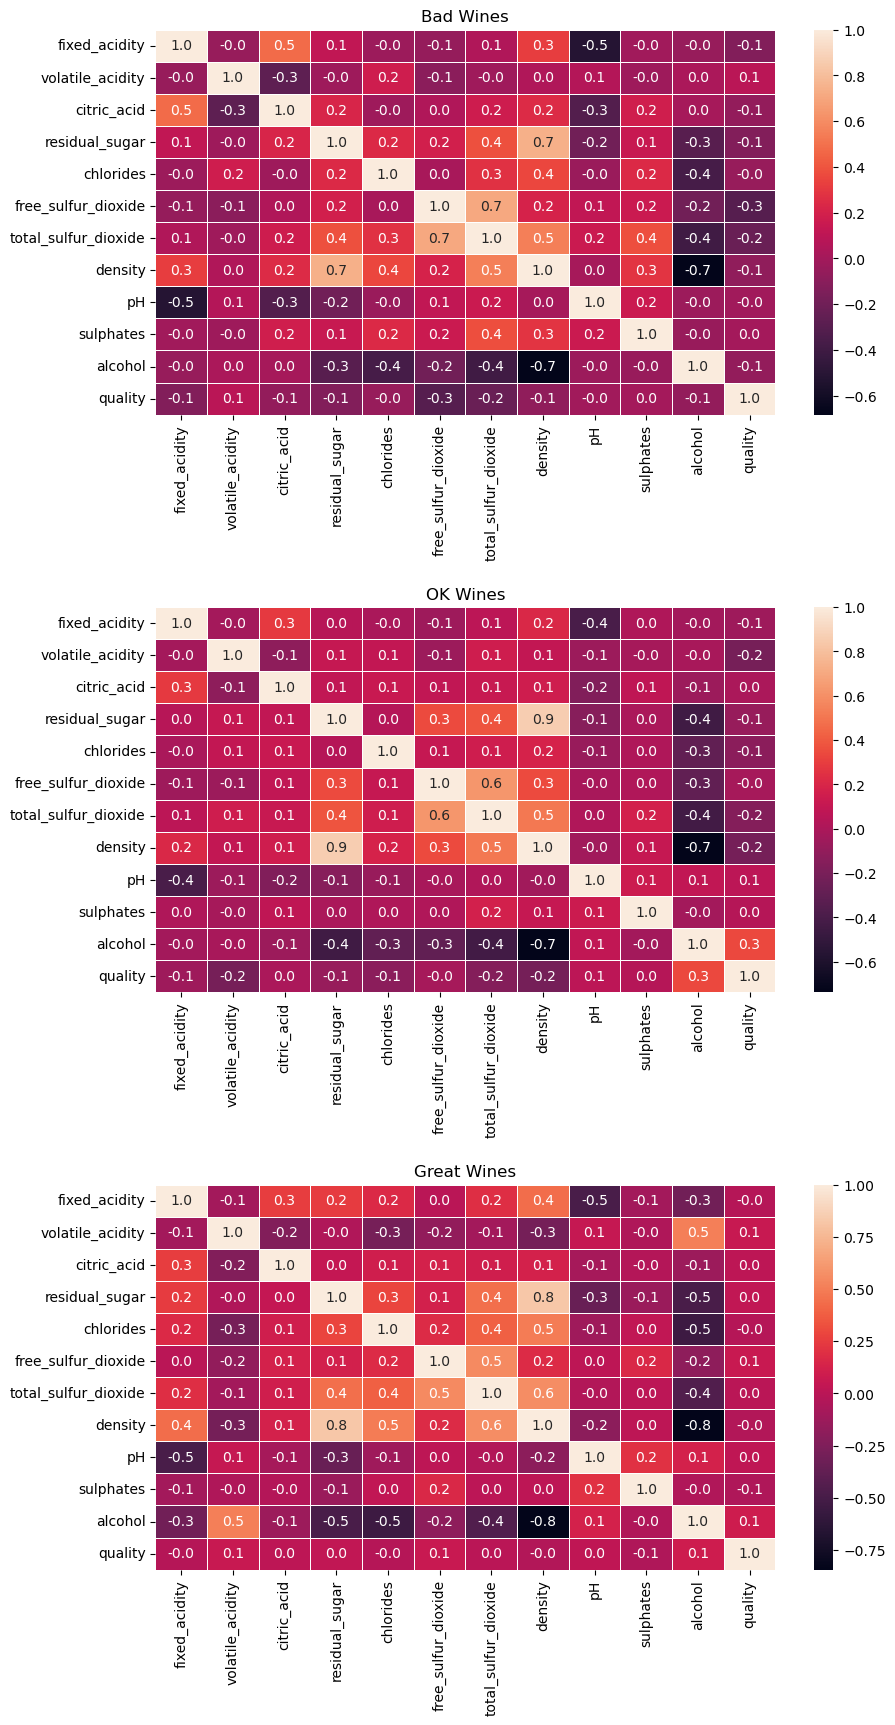

In [125]:
# next, ill explore any possible differences in correlations 
# within the 3 score categories

plt.rcParams["figure.figsize"] = [10, 20]
plt.rcParams["figure.autolayout"] = False

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.5)

ax1.set_title('Bad Wines')
ax2.set_title('OK Wines')
ax3.set_title('Great Wines')

sns.heatmap(bad.corr(), ax=ax1, annot=True, fmt=".1f", linewidth=.5)
sns.heatmap(ok.corr(), ax=ax2, annot=True, fmt=".1f", linewidth=.5)
sns.heatmap(great.corr(), ax=ax3, annot=True, fmt=".1f", linewidth=.5)

plt.show()

# none of the score groups show a significant correlation between 'quality' and any of the other features

In [305]:
# because of the significant 'score' class imbalance, 
# i will combine "bad" and "ok" into one class, and leave "great" as their own class
# then use the "ok" and "great" values as binary 0 and 1 to simplify classification
# and then attempt to build a classifier to predict a "great" wine
df['is_great'] = np.where(df['quality'] >= 7, 1, 0)
print(df['is_great'].value_counts())

0    3838
1    1060
Name: is_great, dtype: int64


In [314]:
# since there is still an imbalance, i will use undersampling to
# create a new dataset with equal number of "ok" and "great" wines
ok_count, great_count = df['is_great'].value_counts()

great = df[df['is_great'] == 1]
ok = df[df['is_great'] == 0]
ok_smaller = ok.sample(great_count)

# new dataset
balanced_data = pd.concat([ok_smaller, great], axis=0)

print('total dataset for analysis', balanced_data.shape)
print('ok wine:', balanced_data[balanced_data['is_great'] == 0].shape)
print('great wine:', balanced_data[balanced_data['is_great'] == 1].shape)

# now create the dataset for training and testing
X_train, X_test = train_test_split(balanced_data, train_size=0.8, test_size=0.2)
print('training:', X_train.shape, 'testing:', X_test.shape)

# split the dependent vars from independent
train_y = X_train['is_great'].values
train_X = X_train.drop(['is_great', 'score', 'score2'], axis=1).values

test_y = X_test['is_great'].values
test_X = X_test.drop(['is_great', 'score', 'score2'], axis=1).values

print('training y:', train_y.shape, 'training x:', train_X.shape)
print('testing y:', test_y.shape, 'testing x:', test_X.shape)

total dataset for analysis (2120, 15)
ok wine: (1060, 15)
great wine: (1060, 15)
training: (1696, 15) testing: (424, 15)
training y: (1696,) training x: (1696, 12)
testing y: (424,) testing x: (424, 12)


In [315]:
# set up metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_conf_mat(conf_matrix):
    plt.close()
    plt.clf()
    plt.rcParams["figure.autolayout"] = False
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    return plt

def plot_roc(roc_auc):
    plt.close()
    plt.clf()        
    plt.rcParams["figure.autolayout"] = False
    plt.figure(figsize=(3, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Great Wine ROC')
    plt.legend(loc="lower right")
    return plt
    
def run_metrics(test_y, yhat):
    # metrics
    print('precision:', precision_score(test_y, yhat))
    print('recall: ', recall_score(test_y, yhat))
    print('accuracy: ', accuracy_score(test_y, yhat))
    print(classification_report(test_y, yhat))

    # roc
    fpr, tpr, thresholds = roc_curve(test_y, yhat)
    roc_auc = auc(fpr, tpr)
    roc_plot = plot_roc(roc_auc)
    roc_plot.show()

    # confusion matrix
    conf_matrix = confusion_matrix(test_y, yhat)
    mat = plot_conf_mat(conf_matrix)
    mat.show()
    
    

precision: 0.754863813229572
recall:  0.8899082568807339
accuracy:  0.7948113207547169
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       206
           1       0.75      0.89      0.82       218

    accuracy                           0.79       424
   macro avg       0.81      0.79      0.79       424
weighted avg       0.80      0.79      0.79       424



<Figure size 400x400 with 0 Axes>

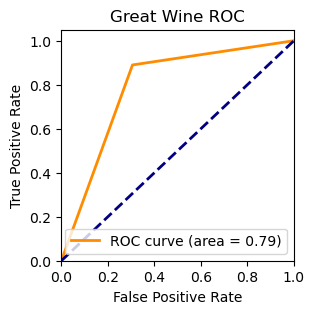

<Figure size 400x400 with 0 Axes>

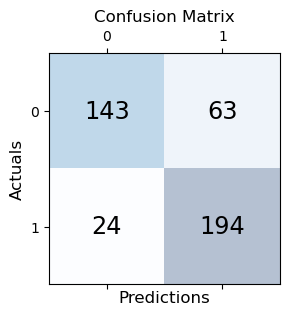

In [316]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_X, train_y)
yhat = knn.predict(test_X)

# metrics
print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()


precision: 0.68
recall:  0.7798165137614679
accuracy:  0.6981132075471698
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       206
           1       0.68      0.78      0.73       218

    accuracy                           0.70       424
   macro avg       0.70      0.70      0.69       424
weighted avg       0.70      0.70      0.70       424



<Figure size 400x400 with 0 Axes>

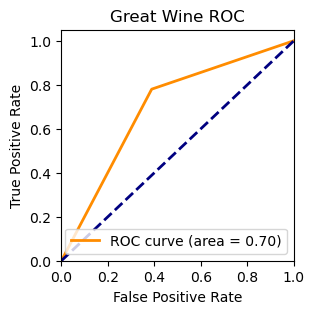

<Figure size 400x400 with 0 Axes>

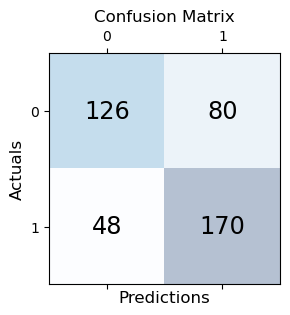

In [317]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 1.0
recall:  1.0
accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      1.00      1.00       218

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



<Figure size 400x400 with 0 Axes>

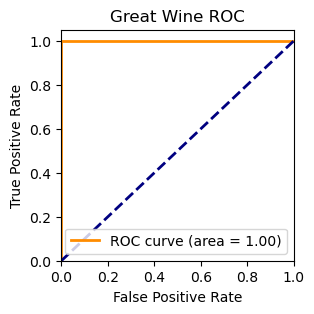

<Figure size 400x400 with 0 Axes>

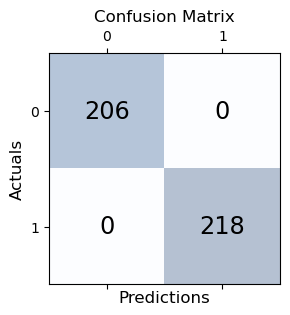

In [318]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 0.8869565217391304
recall:  0.9357798165137615
accuracy:  0.9056603773584906
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       206
           1       0.89      0.94      0.91       218

    accuracy                           0.91       424
   macro avg       0.91      0.90      0.91       424
weighted avg       0.91      0.91      0.91       424



<Figure size 400x400 with 0 Axes>

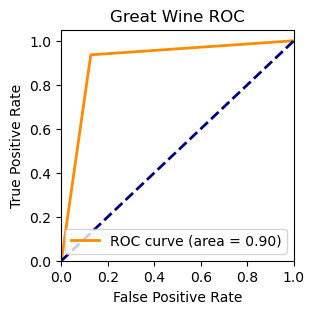

<Figure size 400x400 with 0 Axes>

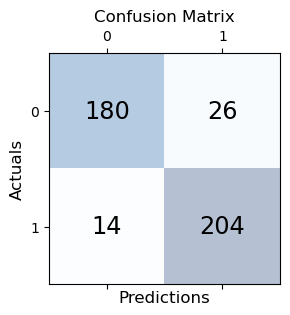

In [319]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 1.0
recall:  1.0
accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      1.00      1.00       218

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



<Figure size 400x400 with 0 Axes>

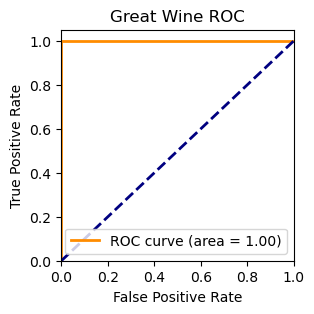

<Figure size 400x400 with 0 Axes>

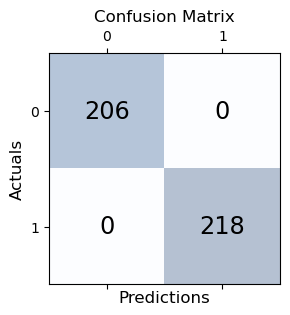

In [320]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

In [ ]:
# todo: analyze decision tree splits
# todo: what did the paper say, what models and metrics they used, whats the EDA
# todo: gridsearch
# todo: more models on raw 'quality' score
# todo: what other interesting predictions besides 'quality' or 'score'
# todo: maybe use both red and white datasets, and try to classify one vs the other?
